# Imports

In [1]:
import numpy as np
import pandas as pd
import os

from skimage.transform import resize   # Image Processing Library
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc    # Garbage Collector
gc.collect()

import random

# Pytorch

import sklearn

import torch
import torchvision

from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

from vocabulary.vocabulary import Vocabulary

from pycocotools.coco import COCO

import nltk

from tqdm import trange

import json

from PIL import Image

In [2]:
# Input data files are available in the "../../../fiftyone/coco-2014" directory.
print(os.listdir("../../fiftyone/coco-2014"))

['info.json', 'raw', 'test', 'train', 'validation']


# Preparation of Dataset and Dataloader

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        PIL_img = Image.open(img_path)
        image = ToTensor()(PIL_img)
        image = image[0].unsqueeze(0)
        # annotation_path = os.path.join(self.annotations_dir, os.listdir(self.annotations_dir)[idx])
        # PIL_annotation = PIL.Image.open(annotation_path)
        # annotation = ToTensor()(PIL_annotation)
        # annotation = annotation[0].unsqueeze(0)
        # annotation = np.transpose(thresh(annotation), (2, 0, 1))
        # annotation = ToTensor()(annotation).permute(2, 0, 1)
        if self.transform:
            image = self.transform(image)
        # if self.target_transform:
        #     annotation = self.target_transform(annotation)
        return image#, annotation

In [4]:
img_dir = "../../fiftyone/coco-2014/train/data/"

In [5]:
annotation_file = "../../fiftyone/coco-2014/train/labels.json"

In [6]:
dataset_test = CustomImageDataset(annotation_file, img_dir)

In [7]:
image = dataset_test[0]

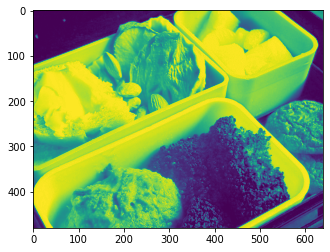

In [8]:
plt.imshow(image.permute(1, 2, 0));

In [9]:
with open("../../fiftyone/coco-2014/raw/captions_train2014.json", 'r') as f:
    train_captions = json.load(f)

In [10]:
train_captions.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [11]:
train_captions["info"]

{'description': 'COCO 2014 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2014,
 'contributor': 'COCO Consortium',
 'date_created': '2017/09/01'}

In [12]:
train_captions["images"][:2]

[{'license': 5,
  'file_name': 'COCO_train2014_000000057870.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 16:28:13',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'id': 57870},
 {'license': 5,
  'file_name': 'COCO_train2014_000000384029.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
  'height': 429,
  'width': 640,
  'date_captured': '2013-11-14 16:29:45',
  'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
  'id': 384029}]

In [13]:
len(train_captions["images"])

82783

In [14]:
train_captions["annotations"][:2]

[{'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'}]

In [15]:
train_captions["annotations"][:2]

[{'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'}]

In [16]:
len(train_captions["annotations"])

414113

In [17]:
train_images_dict = {}

for image in train_captions["images"]:
    train_images_dict[image["id"]] = image["file_name"]

In [18]:
train_caption_dict = {}

for annot in train_captions["annotations"]:
    if annot["image_id"] in train_caption_dict.keys():
        train_caption_dict[annot["image_id"]].append(annot["caption"])
    else:
        train_caption_dict[annot["image_id"]] = [annot["caption"]]

In [ ]:
# Class for Datasets using Custom Images

class CoCoDataset(data.Dataset):

    def __init__(self, transform, mode, batch_size, vocab_threshold, 
                 vocab_file, start_word, end_word, unk_word, annotations_file, 
                 vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word, 
                                end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [
                nltk.tokenize.word_tokenize(
                    str(self.coco.anns[self.ids[index]]['caption']).lower()
                ) for index in tqdm(np.arange(len(self.ids)))
            ]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
            
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where(
            [self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))]
        )[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [ ]:
dataset = CoCoDataset(
    

In [ ]:
# Class for Datasets using Custom Images

class CoCoDataset(data.Dataset):

    def __init__(self, transform, mode, batch_size, vocab_threshold, 
                 vocab_file, start_word, end_word, unk_word, annotations_file, 
                 vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word, 
                                end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [
                nltk.tokenize.word_tokenize(
                    str(self.coco.anns[self.ids[index]]['caption']).lower()
                ) for index in tqdm(np.arange(len(self.ids)))
            ]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
            
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where(
            [self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))]
        )[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [ ]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader